In [5]:
import datasets
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoFeatureExtractor, AutoModelForObjectDetection
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import random


In [6]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("detection-datasets/fashionpedia")

# Split into training and validation sets
train_dataset = dataset["train"].train_test_split(test_size=0.1)["train"]
val_dataset = dataset["train"].train_test_split(test_size=0.1)["test"]


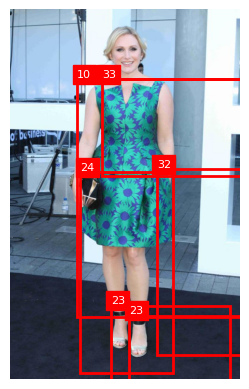

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Show a sample image with bounding boxes
def show_example(example):
    image = example["image"]
    anns = example["objects"]

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for bbox, label in zip(anns["bbox"], anns["category"]):
        x, y, w, h = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, label, color="white", backgroundcolor="red", fontsize=8)

    plt.axis("off")
    plt.show()

# Show one example
show_example(train_dataset[300])


In [7]:
# train_dataset = datasets.load_dataset("detection-datasets/fashionpedia", split=datasets.ReadInstruction("train", from_=0, to=90, unit="%", rounding="pct1_dropremainder"))
# val_dataset = datasets.load_dataset("detection-datasets/fashionpedia", split=datasets.ReadInstruction("train", from_=90, to=100, unit="%", rounding="pct1_dropremainder"))

In [8]:
def xyxy_to_cxcywh(boxes):
    x1, y1, x2, y2 = boxes.unbind(dim=1)
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    return torch.stack((cx, cy, w, h), dim=1)

# feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small")
from transformers import YolosImageProcessor
import torch

# Initialize the image processor
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-small")


In [9]:
import shutil

shutil.rmtree("train_dataset", ignore_errors=True)
shutil.rmtree("val_dataset", ignore_errors=True)


In [10]:
# from datasets import load_from_disk
# # train_dataset.save_to_disk("train_dataset")
# # val_dataset.save_to_disk("val_dataset")

# # Load datasets from disk to avoid in-memory processing
# train_dataset = load_from_disk("train_dataset")
# val_dataset = load_from_disk("val_dataset")

In [11]:
# from PIL import Image

# def transform(example):
#     images = example['image']
#     batch_annotations = example.get("annotations", [])
#     image_ids = example.get("image_id", list(range(len(images))))

#     processed = []

#     for idx, image in enumerate(images):
#         # Convert grayscale to RGB if needed
#         if image.mode == 'L':
#             image = Image.merge('RGB', (image, image, image))

#         # Get annotations for the current image
#         anns = batch_annotations[idx] if batch_annotations else []
#         formatted_anns = []
#         for ann in anns:
#             x_min, y_min, width, height = ann["bbox"]
#             category_id = ann["category_id"]
#             area = width * height
#             formatted_anns.append({
#                 "bbox": [x_min, y_min, width, height],
#                 "category_id": category_id,
#                 "area": area,
#                 "iscrowd": 0
#             })

#         target = {
#             "image_id": image_ids[idx] if isinstance(image_ids, list) else image_ids,
#             "annotations": formatted_anns
#         }

#         encoding = image_processor(images=image, annotations=[target], return_tensors="pt")
#         encoding = {k: v[0] for k, v in encoding.items()}
#         processed.append(encoding)

#     # Convert list of dicts to dict of lists (for Hugging Face Dataset compatibility)
#     batched_output = {k: [d[k] for d in processed] for k in processed[0]}
#     return batched_output

from PIL import Image

def transform(example, image_processor):
    images = example['image']
    batch_annotations = example.get("annotations", [])
    image_ids = example.get("image_id", list(range(len(images))))

    processed = []

    for idx, image in enumerate(images):
        # Convert grayscale to RGB
        if image.mode != 'RGB':
            image = image.convert("RGB")

        # Format annotations for current image
        anns = batch_annotations[idx] if batch_annotations else []
        formatted_anns = []
        for ann in anns:
            x_min, y_min, width, height = ann["bbox"]
            category_id = ann["category_id"]
            area = width * height
            formatted_anns.append({
                "bbox": [x_min, y_min, width, height],
                "category_id": category_id,
                "area": area,
                "iscrowd": 0
            })

        target = {
            "image_id": image_ids[idx] if isinstance(image_ids, list) else image_ids,
            "annotations": formatted_anns
        }

        # Encode using YOLOS image processor
        encoding = image_processor(images=image, annotations=[target], return_tensors="pt")
        encoding = {k: v[0] for k, v in encoding.items()}  # remove batch dim
        processed.append(encoding)

    # Convert list of dicts to dict of lists
    batched_output = {k: [d[k] for d in processed] for k in processed[0]}
    return batched_output


In [12]:
# encoding = encoding[0]
# encoding = image_processor(images=image, annotations=target, return_tensors="pt")
# if isinstance(encoding, list):
#     encoding = {k: v.squeeze(0) for k, v in encoding.items()}


In [15]:
# # Apply transformations with optimized settings
# train_dataset = train_dataset.map(
#     transform,
#     batched=True,
#     batch_size=16,  # Adjust based on your system's memory capacity
#     num_proc=4,     # Utilize multiple processes for parallelism
#     load_from_cache_file=False  # Disable caching to reduce memory overhead
# )

# val_dataset = val_dataset.map(
#     transform,
#     batched=True,
#     batch_size=16,
#     num_proc=4,
#     load_from_cache_file=False
# )

train_dataset = train_dataset.map(
    transform,
    fn_kwargs={"image_processor": image_processor},
    batched=True,
    batch_size=2,  # Reducing batch size to manage memory consumption
    num_proc=1,    # No multiprocessing to avoid additional memory overhead
    keep_in_memory=True,  # Keep data in RAM
    load_from_cache_file=False  # Prevent disk caching
)

val_dataset = val_dataset.map(
    transform,
    fn_kwargs={"image_processor": image_processor},
    batched=True,
    batch_size=2,  # Reduce batch size
    num_proc=1,    # No multiprocessing
    keep_in_memory=True,  # Keep data in RAM
    load_from_cache_file=False  # Prevent disk caching
)



Map:   0%|          | 0/41060 [00:00<?, ? examples/s]

ArrowMemoryError: realloc of size 4294967296 failed

In [17]:
from pathlib import Path
import os

cache_dir = Path.home() / ".cache" / "huggingface" / "datasets"

if cache_dir.exists():
    print(f"\n📁 Hugging Face dataset cache at: {cache_dir}\n")
    for root, dirs, files in os.walk(cache_dir):
        level = root.replace(str(cache_dir), '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}- {os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for f in files:
            print(f"{subindent}{f}")
else:
    print("✅ No cache directory found.")


✅ No cache directory found.


In [18]:
import shutil

total_size = shutil.disk_usage(cache_dir)
used = shutil.disk_usage(cache_dir).used // (1024 ** 2)  # in MB

print(f"\n💾 Cache size used: {used} MB")


FileNotFoundError: [WinError 3] The system cannot find the path specified

#### DELETE THE CACHE FILE CREATED BY THIS CODE 

In [19]:
import shutil
from pathlib import Path

cache_dir = Path.home() / ".cache" / "huggingface" / "datasets"

if cache_dir.exists():
    shutil.rmtree(cache_dir)
    print("✅ Hugging Face dataset cache deleted successfully.")
else:
    print("No cache directory found.")


No cache directory found.


In [ ]:
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small")

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer

class YOLOSLitModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        outputs = self.model(**batch)
        loss = outputs.loss
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=1e-4)

lit_model = YOLOSLitModel(model)
trainer = Trainer(max_epochs=10, gpus=1)
trainer.fit(lit_model, train_loader, val_loader)


In [ ]:
torch.save(model.state_dict(), "yolos_fashion_model.pth")

In [ ]:
# model.load_state_dict(torch.load("yolos_fashion_model.pth"))
# model.eval()


In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision()
model.eval()

for batch in val_loader:
    images = batch["pixel_values"]
    labels = batch["labels"]
    outputs = model(images)
    preds = [{"boxes": output["boxes"], "scores": output["scores"], "labels": output["labels"]} for output in outputs]
    metric.update(preds, labels)

results = metric.compute()
print(results)


In [ ]:
example_input = torch.randn(1, 3, 800, 800)
traced_model = torch.jit.trace(model, example_input)
traced_model.save("yolos_fashion_model.pt")


In [ ]:
# trainer = Trainer(max_epochs=10, gpus=1)
# trainer.fit(model, train_loader, val_loader)


In [ ]:
# model.eval()
# for batch in val_loader:
#     with torch.no_grad():
#         outputs = model(**batch)
#     # Add code to visualize predictions
